In [77]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import graphviz

from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz


In [37]:
# Data Imports
csvfile = "df_training_scholarjet.csv"  # dataset to be used
dataframe_all = pd.read_csv(csvfile, index_col=0)  # read csvs file

# Data manipulation
dataframe_all = dataframe_all.drop(["cuid"], axis=1, inplace=False)  # drop unnecessary columns

df_shape = dataframe_all.shape  # save shape
print(df_shape)

# dataframe_all = dataframe_all.drop(["revenue_30"], axis=1, inplace=False)  # Do classificiation first ***

# dataframe_all = sklearn.utils.shuffle(dataframe_all) # shuffle

dataframe_all.index = range(df_shape[0])  # reindex dataframe
 
# print(dataframe_all.head())

(28126, 182)


In [38]:
# Data Cleaning
# Should I automate the categorical columns that have rankings?

# Find all columns with categorical aka object type data
categorical_data_list = []
for cat in range(df_shape[1]):
    if dataframe_all.dtypes[cat] == 'object':
        categorical_data_list.append(dataframe_all.columns[cat])

# Analyze the categorical data by finding Totals in each Unique categories
# how many are positives where customers bought
# total revenues to see if spending is different by group
def categoricalAnalysis(df, categList, convert, revenue):
    categ_list_len = len(categList)
    
    # lists to add to the returned dataframe
    categTotals = []
    categConvert = []
    categRevenues = []
    percentBuy = []
    
#     for all of the categorical columns
    for cat in range(categ_list_len):
        categTotalsd = {}
        categConvertd = {}
        categRevenuesd = {}
        percentBuyd = {}

        for index in range(len(df[categList[cat]].unique())):
            uniqueCat = df[categList[cat]].unique()[index]  # uniqueCat = iterates through actual unique category list

            categTotalsd[uniqueCat] = df[categList[cat]].value_counts()[uniqueCat]  # totals in cat
    
            #Convert for each cat
            tempDfcon = (df[convert]>0) & (df[categList[cat]] == uniqueCat)
            dfConvert = df[tempDfcon]
            categConvertd[uniqueCat] = dfConvert[convert].sum().round(2)            
        
            #Revenues for each cat
            tempDf = (df[revenue]>0) & (df[categList[cat]] == uniqueCat)
            dfUniqueAbove0 = df[tempDf]
            categRevenuesd[uniqueCat] = dfUniqueAbove0[revenue].sum().round(2)

            percentBuyd[uniqueCat] = categConvertd[uniqueCat] / categTotalsd[uniqueCat] 

            
#         append to lists     
        categTotals.append(categTotalsd)    
        categConvert.append(categConvertd)
        categRevenues.append(categRevenuesd)
        percentBuy.append(percentBuyd)
    d = {'CatColumns':categTotals, 'UniqueCat':categConvert, 'RevCat':categRevenues, 'PercentBuy':percentBuy}
    categorical_data_df = pd.DataFrame(d)
    return categorical_data_df

# call function to create new dataframe of all the raw info on categoricals
analysisDf = categoricalAnalysis(dataframe_all, categorical_data_list, "convert_30", "revenue_30")        

aboveAnalysis = dataframe_all['revenue_30'] > 0
aboveAnalysis = dataframe_all[aboveAnalysis]
pureMean = len(aboveAnalysis) / len(dataframe_all)

def replaceCategCols(df):
    replaceDf = pd.DataFrame(df, copy=True)
    for i, cat in enumerate(categorical_data_list):
        for j, unique in enumerate (replaceDf[cat].unique()):
    #         print(unique, analysisDf.values[i][0][unique] < 1000)
            if (analysisDf.values[i][0][unique]< 100):
                replaceDf[cat].replace(unique, pureMean,inplace=True)
            else:
                replaceDf[cat].replace(unique, analysisDf.values[i][3][unique],inplace=True)
    return replaceDf       

dataframe_all = replaceCategCols(dataframe_all)

In [40]:
# How to transform dataframe into dmatrix

# My competition data in dataframe form
y = pd.DataFrame(dataframe_all['convert_30'], copy=True)
X = pd.DataFrame(dataframe_all, copy=True)
X.drop(['convert_30', 'revenue_30'], axis=1, inplace=True)

# Split 
# do I need to do a training split?
from sklearn.model_selection import train_test_split
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [55]:
data = X_train
label = y_train
dtrain = xgb.DMatrix(data, label=label)

dataTest = X_test
labelTest = y_test
dtest = xgb.DMatrix(dataTest, label=labelTest)


# len(dtrain.get_label())

param = {'max_depth': 2,
         'eta': 1,
         'silent': 1,
         'objective': 'binary:logistic',
         'nthread': 4,
         'eval_metric': 'auc'}

evallist = [(dtest, 'eval'), (dtrain, 'train')]


num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.749572	train-auc:0.744054
[1]	eval-auc:0.770575	train-auc:0.768263
[2]	eval-auc:0.798221	train-auc:0.793227
[3]	eval-auc:0.805526	train-auc:0.799288
[4]	eval-auc:0.811922	train-auc:0.805722
[5]	eval-auc:0.810781	train-auc:0.810428
[6]	eval-auc:0.811172	train-auc:0.814856
[7]	eval-auc:0.81222	train-auc:0.81634
[8]	eval-auc:0.810961	train-auc:0.817494
[9]	eval-auc:0.811445	train-auc:0.819104
[10]	eval-auc:0.811826	train-auc:0.820401
[11]	eval-auc:0.810853	train-auc:0.821078
[12]	eval-auc:0.810446	train-auc:0.822046
[13]	eval-auc:0.81174	train-auc:0.822869
[14]	eval-auc:0.810674	train-auc:0.823308
[15]	eval-auc:0.812437	train-auc:0.824567
[16]	eval-auc:0.811218	train-auc:0.82596
[17]	eval-auc:0.811563	train-auc:0.827293
[18]	eval-auc:0.811033	train-auc:0.827922
[19]	eval-auc:0.810398	train-auc:0.829282


matplotlib.axes._subplots.AxesSubplot

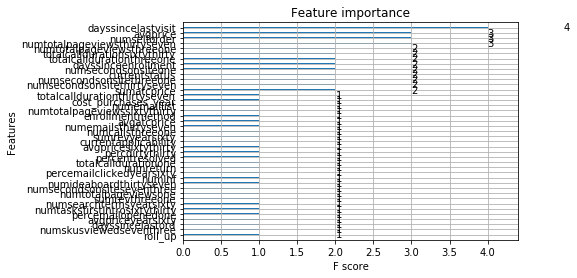

In [84]:
ypred = bst.predict(dtest)
xgb.plot_importance(bst)

